In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

In [295]:
@njit
def agrad(a, sigma, x, y, lam):
    z = 4 + a**2 + 2*sigma**2*(2 + a**2)
    zeta = 1 + 2*sigma**2
    xi = 1 + sigma**2
    k = 1 + a**2

    gr1 = 2*(16 + a**2)*(-1 + lam)*z*zeta
    gr1 *= 5*a*x**2 + 2*a**3*x**2 - 4*x*y - 3*a**2*x*y + a*y**2 + 2*(a*x - y)*(x + 2*a**2*x - a*y)*sigma**2
    gr2 = 2*a*(-1 + lam)*(z-2*zeta*(16 + a**2))
    gr2 *= (3 + k)*(-2*a*x*y + y**2 + x**2*k) + 4*(a*x - y)*(-y*(1 + k) + a*x*(2+k))*sigma**2 + 4*(-a*x + y)**2*k*sigma**4

    gr3 = a**6*x*y*zeta**3 + a**5*zeta**3*(-1 +2*x**2-y**2) - 16*x*y*xi + 8*a*zeta*(x**2 + y**2*xi - xi)
    gr3 += 2*a**3*zeta**2*(-3 + 4*x**2 -2*sigma**2) -4*a**4*x*y*(sigma + 2*sigma**3)**2 - 4*a**2*x*y*(3 + 10*sigma**2 + 8*sigma**4)
    gr3 *= -2*z*zeta*lam/(2 + a**2*zeta)**2

    gr4 = (16 + a**2)*(-1 + lam)
    gr4 *= (3 + k)*(-2*a*x*y + y**2 + x**2*k) + 4*(a*x - y)*(-y*(1 + k) + a*x*(2+k))*sigma**2 + 4*(-a*x + y)**2*k*sigma**4
    gr4 *= 1/z**2
    gr4 += lam/2*(-2*(-a*x + y)**2/(1+k) + x**2/xi + 2*y**2/(1 + k +2*a**2*sigma**2) - 2*(2*x + a*y)**2/(8 + 6*a**2 + a**4 + 2*(1+k)**2*sigma**2) + np.log(2*(2+a**2*zeta)*xi/z))
    gr4 *= -z*zeta*(a**3*zeta + 2*a**2*x*y*zeta -8*x*y*xi + 4*a*(x**2*zeta + xi - y**2*xi))

    return (gr1 + gr2 + gr3 + gr4)/np.exp(3*np.log(z))

In [330]:
@njit
def simulate_xyeta(Nsteps, dt, sigma, theta_eta, lam = 0.9, tau_x = 1, theta_y = 1, tau_a = 1):
    x = np.zeros(Nsteps, dtype=np.float64)
    y = np.zeros(Nsteps, dtype=np.float64)
    eta = np.zeros(Nsteps, dtype=np.float64)
    a = np.zeros(Nsteps, dtype=np.float64)
    grads = np.zeros(Nsteps - 1, dtype=np.float64)

    x0 = np.random.randn()
    y0 = np.random.randn()
    eta0 = np.random.randn()
    a0 = 0

    tau_y = theta_y * tau_x
    tau_eta = theta_eta * tau_x
    sqtau_x = np.sqrt(dt/tau_x)
    sqtau_y = np.sqrt(dt/tau_y)
    sqtau_eta = np.sqrt(dt/tau_eta)

    x[0] = x0
    y[0] = y0
    eta[0] = eta0
    a[0] = a0


    for t in range(Nsteps-1):
        y[t + 1] = y[t] + dt * (-y[t] + a[t] * x[t])/tau_y + np.random.randn() * sqtau_y
        x[t + 1] = x[t] + dt * (-x[t] + sigma * eta[t])/tau_x + np.random.randn() * sqtau_x
        eta[t + 1] = eta[t] + dt * (-eta[t])/tau_eta + np.random.randn() * sqtau_eta
        grads[t] = agrad(a[t], sigma, x[t], y[t], lam)
        a[t + 1] = a[t] + dt * agrad(a[t], sigma, x[t], y[t], lam)/tau_a
        
        
    return x, y, eta, a, grads

In [375]:
Nsteps = int(5e8)
dt = 1e-5
sigma = 2

theta_eta = 1000

Time = np.arange(0, Nsteps) * dt
x, y, eta, a, grads = simulate_xyeta(Nsteps, dt, sigma, theta_eta, tau_a = 50, lam = 0.3)
#a = a[int(1e7):]
np.mean(abs(a))

0.34754978677052717

In [376]:
plt.plot(a)
plt.show()

np.mean(abs(a))

: 

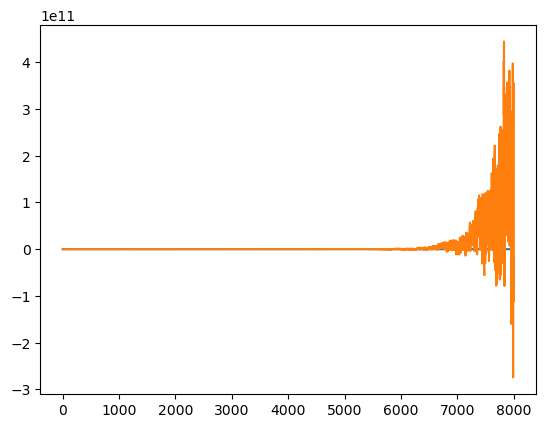

In [158]:
plt.plot(Time, x, label='x')
plt.plot(Time, y, label='y')
plt.show()